In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from albertaC19_webscraper import albertaC19_webscraper

In [2]:
abC19scaper = albertaC19_webscraper()
abTotal, abRegion, abTesting = abC19scaper.scrape_all(return_dataframes=True)

In [40]:
def calculate_cumulatives(df:pd.DataFrame, filter_suffix:str='newCases', col_suffix:str='cumCases', combine_df:bool=True):
    '''
    take the dataframe and calculate the cumulative cases. Will only select columns with
    the base key in the column name. returns a new dataframe
    
    Parameters:
        df:pd.DataFrame
            the dataframe contaning the new cases data
        filter_suffix:str
            the string to use for filtering the dataframe using pd.DataFrame.filter(like=like_filter)
        col_suffix:str
            will use like_filter and old column names to determine the new cumulative column name
            for example would find Cal_newCases and determine new column should be Cal_cumCases
        combine_df:bool
            if True will return a new dataframe with the cumulative data joined with the old dataframe
            if False will only return a dataframe with the cumulative data
            
    Returns:
        cum_df:pd.DataFrame
            new dataframe 
    '''
    filtered_df = df.filter(like=filter_suffix)
    # create map for new columns
    filt_cols = filtered_df.columns.to_list()
    new_cols = [col.replace(filter_suffix, col_suffix) for col in filt_cols]
    col_dict = dict(zip(filt_cols, new_cols))
    # make new dataframe
    cum_df = filtered_df.cumsum()
    cum_df.rename(columns=col_dict, inplace=True)
    if combine_df:
        return df.join(cum_df)
    return cum_df

In [ ]:
# increase33 = int(np.ceil(cum_data.iloc[old_idx]['cumsum'] * 1.33))

In [91]:
def calculate_doublingtimes_region(df:pd.DataFrame, col_suffix:str='cumCases',
                                   median_incubation_period:float=5.2, combine_df=True):
    '''
    given a dataframe look through and calculate the doubling times. Both doubling time based
    on the first occurance of covid-19 and doubling time based on a rolling window which 
    looks back as far as the median incubation period (converted to integer using ceiling)
    
    Parameters:
        df: pd.DataFrame
            the dataframe containing the region data
        col_suffix:str
            cumulative column suffix used to filter the dataframe to only grab cumulative data
            uses pd.DataFrame.filter(like=col_suffix)
        combine_df:bool
            if True will return a new dataframe with the doubling time data joined with the old dataframe
            if False will only return a dataframe with the doubling time data
    Return:
        regionDF_doublingtime: DataFrame
    '''
    median_incub_prd = np.ceil(median_incubation_period)
    filtered_df = df.filter(like=col_suffix)
    doubling_time = dict()
    for label, cum_data in filtered_df.iteritems():
        start_idx = cum_data.to_numpy().nonzero()[0][0] # assumes date is used as df index
        min_idx_rw = start_idx + median_incub_prd
        start_cases = cum_data.iloc[start_idx]
        start_date = cum_data.index[start_idx]
        
        dt_values = [0]
        dt_key = label.replace(col_suffix, 'dtime')
        dt_rw_values = [0]
        dt_rw_key = label.replace(col_suffix, 'dtime_rw')
        
        for idx in range(1, len(cum_data)):
            old_idx = idx - 1

            new_cases = cum_data.iloc[idx]
            new_date = cum_data.index[idx]
            old_cases = cum_data.iloc[old_idx]

            # calculate the doubling time
            t_delta = new_date - start_date
            c_delta = new_cases / start_cases
            
            dtime = 0 # default
            if c_delta > 1: # log(1) = 0, log(x) with x: 0 < x > 1 is equal to a negative number
                dtime = ( t_delta.days * np.log(2) ) / ( np.log(c_delta))
            dt_values.append(dtime)
            
            # Rolling window calculation
            dtime_rw = 0 # default
            if idx >= min_idx_rw:
                idx_rw = idx - 6
                old_cases_rw = cum_data.iloc[idx_rw]
                old_date_rw = cum_data.index[idx_rw]
                # calculate the doubling time
                t_delta_rw = new_date - old_date_rw
                c_delta_rw = new_cases / old_cases_rw
                if c_delta_rw > 1: # log(1) = 0, log(x) with x: 0 < x > 1 is equal to a negative number
                    dtime_rw = ( t_delta_rw.days * np.log(2) ) / ( np.log(c_delta_rw))
            dt_rw_values.append(dtime_rw)
            
        doubling_time[dt_key] = dt_values
        doubling_time[dt_rw_key] = dt_rw_values
    df_dt = pd.DataFrame(doubling_time, index=filtered_df.index)
    if combine_df:
        return df.join(df_dt)
    return df_dt

In [93]:
region_cum = calculate_cumulatives(abRegion, combine_df=False)
region_dt = calculate_doublingtimes_region(region_cum, combine_df=False)
total_dt = calculate_doublingtimes_region(abTotal, col_suffix='cum_cases', combine_df=False)

,dtime,dtime_rw
2020-03-06,0.000000,0.0
2020-03-09,1.068622,0.0
2020-03-10,1.000000,0.0
2020-03-11,1.105324,0.0
2020-03-12,1.292030,0.0


In [86]:
print(region_cum.columns.to_list())
print(abTotal.columns.to_list())

['Calgary_cumCases', 'Central_cumCases', 'Edmont_cumCases', 'North_cumCases', 'South_cumCases', 'Unknown_cumCases']
['new_cases', 'cum_cases']


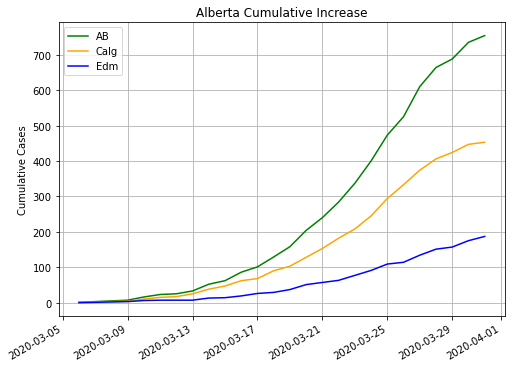

In [113]:
fig, ax = plt.subplots(figsize=(8,6))
abTotal['cum_cases'].plot(ax=ax, label='AB', c='green')
region_cum['Calgary_cumCases'].plot(ax=ax, label='Calg', c='orange')
region_cum['Edmont_cumCases'].plot(ax=ax, label='Edm', c='blue')

ax.grid(which='both')
ax.set_ylabel('Cumulative Cases')
ax.set_title('Alberta Cumulative Increase')
ax.legend()
fig.savefig('images/AlbertaCumIncrease.png', bbox_inches='tight')

In [94]:
print(region_dt.columns.to_list())
print(total_dt.columns.to_list())

['Calgary_dtime', 'Calgary_dtime_rw', 'Central_dtime', 'Central_dtime_rw', 'Edmont_dtime', 'Edmont_dtime_rw', 'North_dtime', 'North_dtime_rw', 'South_dtime', 'South_dtime_rw', 'Unknown_dtime', 'Unknown_dtime_rw']
['dtime', 'dtime_rw']


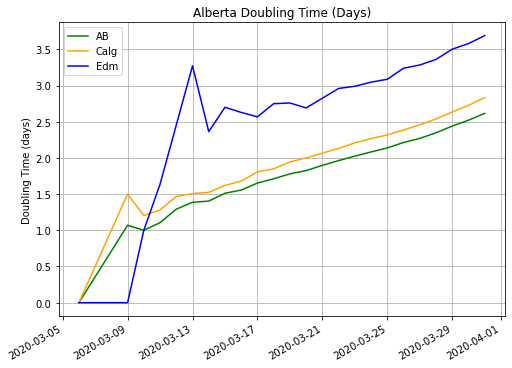

In [114]:
fig, ax = plt.subplots(figsize=(8,6))
total_dt['dtime'].plot(ax=ax, label='AB', c='green')
region_dt['Calgary_dtime'].plot(ax=ax, label='Calg', c='orange')
region_dt['Edmont_dtime'].plot(ax=ax, label='Edm', c='blue')

ax.legend()
ax.grid(which='both')
ax.set_ylabel('Doubling Time (days)')
ax.set_title('Alberta Doubling Time (Days)')
fig.savefig('images/AlbertaDTimeIncrease.png', bbox_inches='tight')

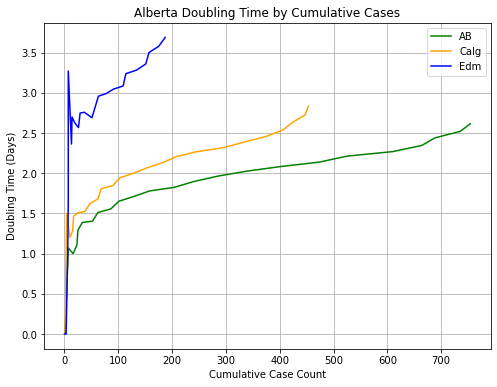

In [115]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(abTotal['cum_cases'].values, total_dt['dtime'].values, 
        c='green', label='AB')
ax.plot(region_cum['Calgary_cumCases'].values, region_dt['Calgary_dtime'].values, 
        c='orange', label='Calg')
ax.plot(region_cum['Edmont_cumCases'].values, region_dt['Edmont_dtime'].values, 
        c='blue', label='Edm')
ax.grid(which='both')
ax.legend()
ax.set_ylabel('Doubling Time (Days)')
ax.set_xlabel('Cumulative Case Count')
ax.set_title("Alberta Doubling Time by Cumulative Cases")
fig.savefig('images/AlbertaDTimeIncrease_byCaseCount.png', bbox_inches='tight')

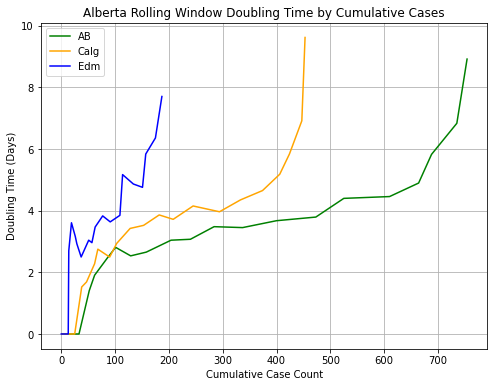

In [116]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(abTotal['cum_cases'].values, total_dt['dtime_rw'].values, 
        c='green', label='AB')
ax.plot(region_cum['Calgary_cumCases'].values, region_dt['Calgary_dtime_rw'].values, 
        c='orange', label='Calg')
ax.plot(region_cum['Edmont_cumCases'].values, region_dt['Edmont_dtime_rw'].values, 
        c='blue', label='Edm')
ax.grid(which='both')
ax.legend()
ax.set_ylabel('Doubling Time (Days)')
ax.set_xlabel('Cumulative Case Count')
ax.set_title("Alberta Rolling Window Doubling Time by Cumulative Cases")
fig.savefig('images/AlbertaDTimeIncreaseRW_byCaseCount.png', bbox_inches='tight')

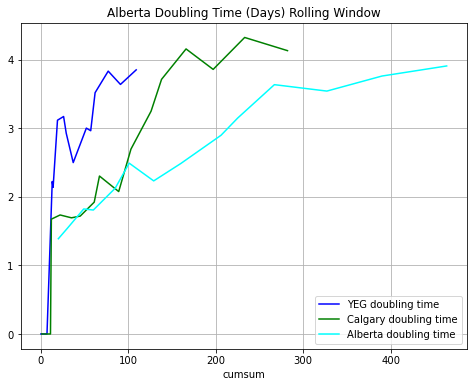

In [202]:
fig, ax = plt.subplots(figsize=(8,6))
covid.groupby(['Zone']).get_group('Edmonton').plot(y='dtime_rw', 
                                                   x='cumsum', 
                                                   ax=ax, 
                                                   label="YEG doubling time",
                                                   color='blue')
covid.groupby(['Zone']).get_group('Calgary').plot(y='dtime_rw', 
                                                  x='cumsum', 
                                                  ax=ax, 
                                                  label="Calgary doubling time",
                                                  color='green')
totals.plot(y='dtime_rw', x='cumsum',  ax=ax, 
            label="Alberta doubling time", color='cyan')

ax.grid(which='both')
ax.set_title('Alberta Doubling Time (Days) Rolling Window')
fig.savefig('AlbertaDTimeIncreaseRW_byCaseCount.png', bbox_inches='tight')

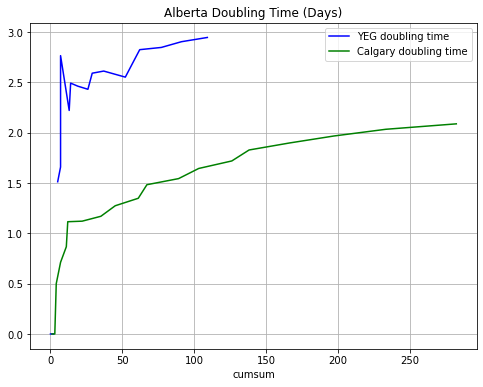

In [201]:
fig, ax = plt.subplots(figsize=(8,6))
covid.groupby(['Zone']).get_group('Edmonton').plot(y='dtime', 
                                                   x='cumsum', 
                                                   ax=ax, 
                                                   label="YEG doubling time",
                                                   color='blue')
covid.groupby(['Zone']).get_group('Calgary').plot(y='dtime', 
                                                  x='cumsum', 
                                                  ax=ax, 
                                                  label="Calgary doubling time",
                                                  color='green')
# totals.plot(y='dtime', x='Date',  ax=ax, 
#             label="Alberta doubling time", color='cyan')

ax.grid(which='both')
ax.set_title('Alberta Doubling Time (Days)')
fig.savefig('AlbertaDTimeIncrease_byCaseCount.png', bbox_inches='tight')

In [195]:
covid.to_csv('covid_analysis.csv')